# Analysing the Sentiment of Drug Reviews

This is a project whose main goal is to estimate if a review of a given drug is positive or negative, as well as the occurence of positive or negative terms. This project uses the [Drug Review Database](https://www.kaggle.com/datasets/mohamedabdelwahabali/drugreview) for training and evaluation.

## 1. Importing modules

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import re
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


from collections import Counter

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import load_model

sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 2. Loading the Dataset

After importing the required libraries, we now proceed with loading the dataset to be used. \
Obs.: The dataset was downloaded locally, so it was loaded directly from its file path.

In [2]:
# loading training, validation and test datasets
train_df = pd.read_csv("archive/drug_review_train.csv")
valid_df = pd.read_csv("archive/drug_review_validation.csv")
test_df = pd.read_csv("archive/drug_review_test.csv")

In [3]:
#### This cell is used to set the working directory so that the program can access the data files

import os
# changing directory to the one where notebook was placed
os.chdir("C:\\Users\\chris\\Documents\\GitHub Projects\\Advanced Study, Foundation and Practical Data Science Projects\\Practice Projects\\Sentiment Analysis\\Drug Review")
print(os.getcwd())

c:\Users\chris\Documents\GitHub Projects\Advanced Study, Foundation and Practical Data Science Projects\Practice Projects\Sentiment Analysis\Drug Review


In [4]:
# check training dataframe
train_df.head()

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136
2,2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140
3,3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74


In [5]:
# checking validation dataframe
valid_df.head()

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,191114,Campral,alcohol dependence,"""sober a year 8-25-11. god, aa and campral hav...",10.0,"September 3, 2011",33,41
1,1,142693,Levonorgestrel,birth control,"""i've been on birth control for a while now du...",4.0,"August 9, 2017",3,140
2,2,71561,Vraylar,bipolar disorde,"""hi, this is an updated experience. \r\r\n\r\r...",8.0,"August 16, 2016",12,131
3,3,25765,Ethinyl estradiol / norelgestromin,birth control,"""i have been on the ortho evra patch for just ...",8.0,"September 15, 2013",16,138
4,4,12843,Etanercept,psoriasis,"""i have been on enbrel for 7 years and i have ...",9.0,"August 5, 2010",9,65


In [6]:
# checking test dataframe
test_df.head()

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,163740,Mirtazapine,depression,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012",22,68
1,1,206473,Mesalamine,"crohn's disease, maintenance","""my son has crohn's disease and has done very ...",8.0,"May 17, 2009",17,48
2,2,39293,Contrave,weight loss,"""contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,143
3,3,97768,Cyclafem 1 / 35,birth control,"""i have been on this birth control for one cyc...",9.0,"October 22, 2015",4,149
4,4,208087,Zyclara,keratosis,"""4 days in on first 2 weeks. using on arms an...",4.0,"July 3, 2014",13,60


In [7]:
# getting the shapes of the dataframes

print(f"Train data shape: {train_df.shape}\nValidation data shape: {valid_df.shape}\nTest data shape: {test_df.shape}")

Train data shape: (110811, 9)
Validation data shape: (27703, 9)
Test data shape: (46108, 9)


## 3. Exploratory Data Analysis

Before going on creating and training a model, some data analysis is performed. First of all, we'll check if there is something missing data in the imported files.

In [8]:
# Checking if relevant columns contain null values

print("Number of null reviews in training set:", train_df['review'].isnull().sum())
print("Number of null reviews in validation set:", valid_df['review'].isnull().sum())
print("Number of null reviews in test set:", test_df['review'].isnull().sum())

print("Number of null ratings in training set:", train_df['rating'].isnull().sum())
print("Number of null ratings in validation set:", valid_df['rating'].isnull().sum())
print("Number of null ratings in test set:", test_df['rating'].isnull().sum())

Number of null reviews in training set: 0
Number of null reviews in validation set: 0
Number of null reviews in test set: 0
Number of null ratings in training set: 0
Number of null ratings in validation set: 0
Number of null ratings in test set: 0


Then, we'll check the data distribution according to the rating and the number of words per review.

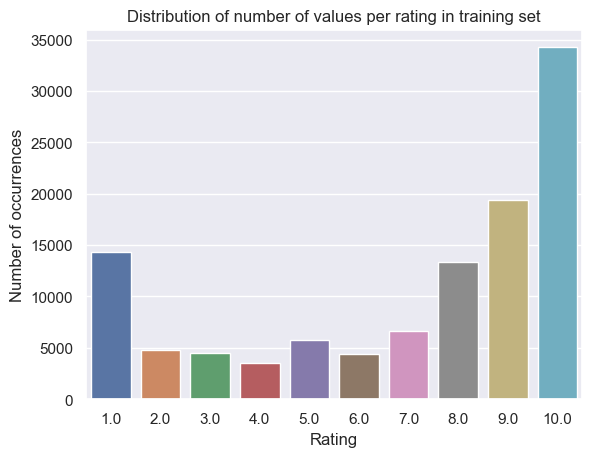

In [9]:
balance = pd.DataFrame(train_df["rating"].value_counts())
sns.barplot(balance, x = balance.index, y = "count")
plt.xlabel("Rating")
plt.ylabel("Number of occurrences")
plt.title("Distribution of number of values per rating in training set")
plt.show()

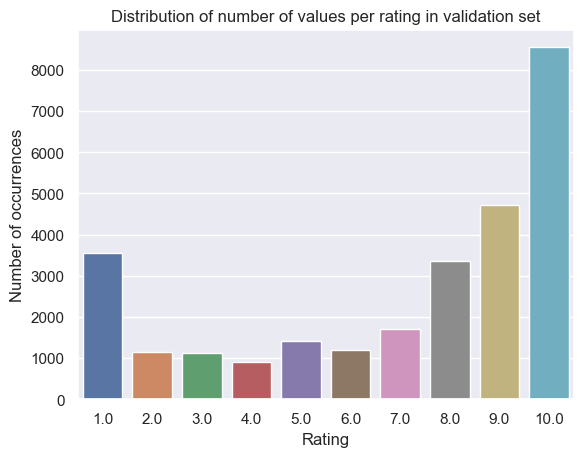

In [10]:
balance = pd.DataFrame(valid_df["rating"].value_counts())
sns.barplot(balance, x = balance.index, y = "count")
plt.xlabel("Rating")
plt.ylabel("Number of occurrences")
plt.title("Distribution of number of values per rating in validation set")
plt.show()

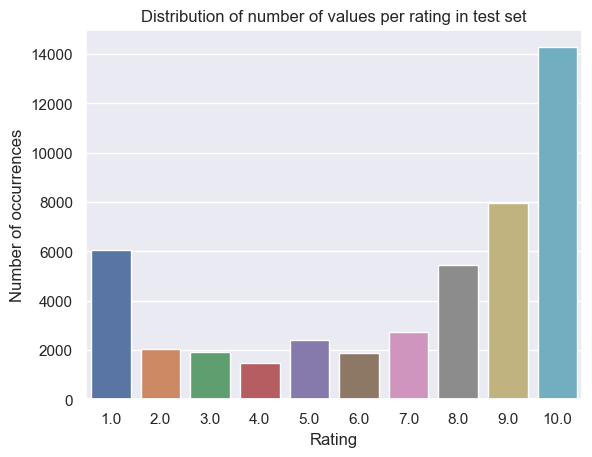

In [11]:
balance = pd.DataFrame(test_df["rating"].value_counts())
sns.barplot(balance, x = balance.index, y = "count")
plt.xlabel("Rating")
plt.ylabel("Number of occurrences")
plt.title("Distribution of number of values per rating in test set")
plt.show()

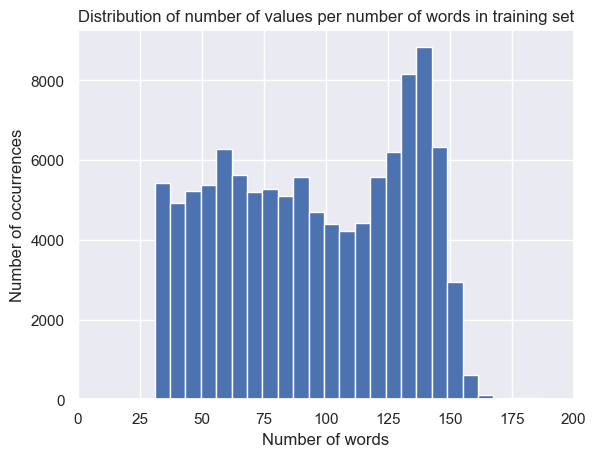

In [12]:
plt.hist(train_df["review_length"].values, bins = 300)
plt.xlabel("Number of words")
plt.ylabel("Number of occurrences")
plt.title("Distribution of number of values per number of words in training set")
plt.xlim(0, 200)
plt.show()

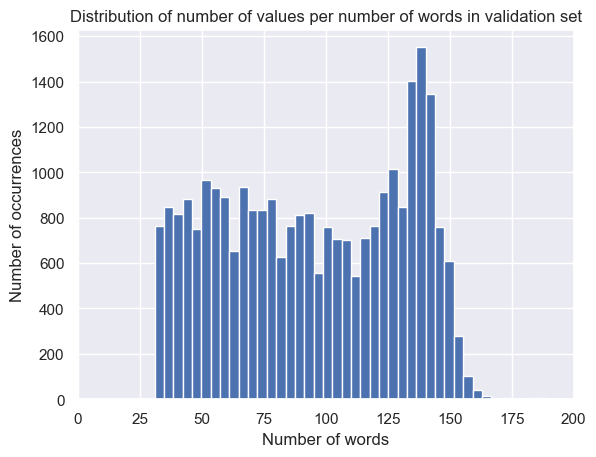

In [13]:
plt.hist(valid_df["review_length"].values, bins = 300)
plt.xlabel("Number of words")
plt.ylabel("Number of occurrences")
plt.title("Distribution of number of values per number of words in validation set")
plt.xlim(0, 200)
plt.show()

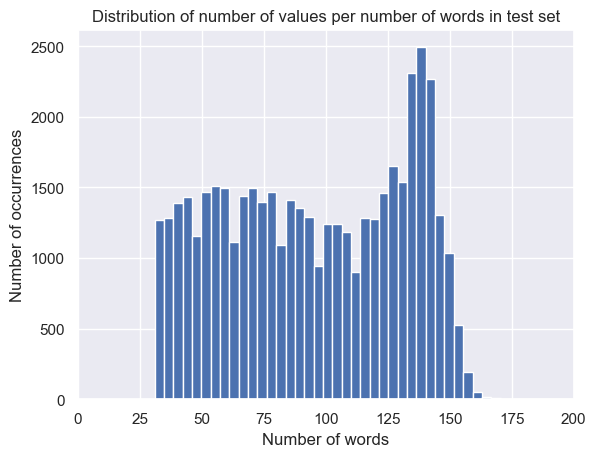

In [14]:
plt.hist(test_df["review_length"].values, bins = 300)
plt.xlabel("Number of words")
plt.ylabel("Number of occurrences")
plt.title("Distribution of number of values per number of words in test set")
plt.xlim(0, 200)
plt.show()

As noticed in the graphs, the training, validation and test sets have the same distribution regarding rating and number of words per review. Also, both rating and review columns have no empty values, which means there are no rows to eliminate from this criteria.

### 4. Processing the data

After loading the data and exploring it, we proceed with the data preparation. At first, let's select the relevant columns for our project.

In [15]:
selected_columns = ["patient_id", "drugName", "review", "rating", "date"]
train_df = train_df[selected_columns]
valid_df = valid_df[selected_columns]
test_df = test_df[selected_columns]

In [16]:
train_df.head()

,patient_id,drugName,review,rating,date
0,89879,Cyclosporine,"""i have used restasis for about a year now and...",2.0,"April 20, 2013"
1,143975,Etonogestrel,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016"
2,106473,Implanon,"""this is my second implanon would not recommen...",1.0,"May 11, 2016"
3,184526,Hydroxyzine,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012"
4,91587,Dalfampridine,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010"


In [17]:
valid_df.head()

,patient_id,drugName,review,rating,date
0,191114,Campral,"""sober a year 8-25-11. god, aa and campral hav...",10.0,"September 3, 2011"
1,142693,Levonorgestrel,"""i've been on birth control for a while now du...",4.0,"August 9, 2017"
2,71561,Vraylar,"""hi, this is an updated experience. \r\r\n\r\r...",8.0,"August 16, 2016"
3,25765,Ethinyl estradiol / norelgestromin,"""i have been on the ortho evra patch for just ...",8.0,"September 15, 2013"
4,12843,Etanercept,"""i have been on enbrel for 7 years and i have ...",9.0,"August 5, 2010"


In [18]:
test_df.head()

,patient_id,drugName,review,rating,date
0,163740,Mirtazapine,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012"
1,206473,Mesalamine,"""my son has crohn's disease and has done very ...",8.0,"May 17, 2009"
2,39293,Contrave,"""contrave combines drugs that were used for al...",9.0,"March 5, 2017"
3,97768,Cyclafem 1 / 35,"""i have been on this birth control for one cyc...",9.0,"October 22, 2015"
4,208087,Zyclara,"""4 days in on first 2 weeks. using on arms an...",4.0,"July 3, 2014"


Then, we start processing the text column so that it can be used in the model. Let's begin with removing special characters, like tabs or new lines. We'll also remove the digits:

In [19]:
remove_special_chars = lambda x: re.sub(r"\\.", "", str(x))
train_df.review = train_df.review.apply(remove_special_chars)
valid_df.review = valid_df.review.apply(remove_special_chars)
test_df.review = test_df.review.apply(remove_special_chars)

In [20]:
remove_digits = lambda x: re.sub(r"[0-9]", "", str(x))
train_df.review = train_df.review.apply(remove_digits)
valid_df.review = valid_df.review.apply(remove_digits)
test_df.review = test_df.review.apply(remove_digits)

In [8]:
# verifying training reviews
train_df.review

0         "i have used restasis for about a year now and...
1         "my experience has been somewhat mixed. i have...
2         "this is my second implanon would not recommen...
3         "i recommend taking as prescribed, and the bot...
4         "i have been on ampyra for  days and have been...
                                ...                        
110806    "i had tried many medications to level out my ...
110807    "had partial thyroid removal with benign tumor...
110808    "my experience with risperdal started when i f...
110809    "my elderly dad was prescribed a low dose of a...
110810    "latuda has been a hero in my battle against s...
Name: review, Length: 110811, dtype: object

In [9]:
# verifying validation reviews
valid_df.review

0        "sober a year --. god, aa and campral have wor...
1        "i've been on birth control for a while now du...
2        "hi, this is an updated experience. \r\r\n\r\r...
3        "i have been on the ortho evra patch for just ...
4        "i have been on enbrel for  years and i have t...
                               ...                        
27698    "after my first and only shot, ten days after ...
27699    "i have been on velivet for about a year. it h...
27700    "i have been taking zarah for almost  months. ...
27701    "i had my first seizure february  and was pres...
27702    "i've been on aviane for about  weeks. i'm on ...
Name: review, Length: 27703, dtype: object

In [10]:
# verifying test reviews
test_df.review

0        "i've tried a few antidepressants over the yea...
1        "my son has crohn's disease and has done very ...
2        "contrave combines drugs that were used for al...
3        "i have been on this birth control for one cyc...
4        " days in on first  weeks.  using on arms and ...
                               ...                        
46103    "i started taking apri about  months ago. my b...
46104    "i have taken tamoxifen for  years. side effec...
46105    "i've been taking lexapro (escitaploprgram) si...
46106    "i'm married,  years old and i have no kids. t...
46107    "i was prescribed nucynta for severe neck/shou...
Name: review, Length: 46108, dtype: object

We then convert all characters to lowercase and remove any punctuation:

In [21]:
# converting all characters to lowercase
to_lower = lambda x: x.lower()
train_df.review = train_df.review.apply(to_lower)
valid_df.review = valid_df.review.apply(to_lower)
test_df.review = test_df.review.apply(to_lower)

# removing puncuation
remove_puncs = lambda x: x.translate(str.maketrans("", "", string.punctuation))
train_df.review = train_df.review.apply(remove_puncs)
valid_df.review = valid_df.review.apply(remove_puncs)
test_df.review = test_df.review.apply(remove_puncs)

In [22]:
# verifying training reviews
train_df.review

0         i have used restasis for about a year now and ...
1         my experience has been somewhat mixed i have b...
2         this is my second implanon would not recommend...
3         i recommend taking as prescribed and the bottl...
4         i have been on ampyra for  days and have been ...
                                ...                        
110806    i had tried many medications to level out my b...
110807    had partial thyroid removal with benign tumor ...
110808    my experience with risperdal started when i fi...
110809    my elderly dad was prescribed a low dose of at...
110810    latuda has been a hero in my battle against sc...
Name: review, Length: 110811, dtype: object

In [23]:
# verifying validation reviews
valid_df.review

0        sober a year  god aa and campral have worked n...
1        ive been on birth control for a while now due ...
2        hi this is an updated experience \r\r\n\r\r\ni...
3        i have been on the ortho evra patch for just o...
4        i have been on enbrel for  years and i have to...
                               ...                        
27698    after my first and only shot ten days after i ...
27699    i have been on velivet for about a year it has...
27700    i have been taking zarah for almost  months i ...
27701    i had my first seizure february  and was presc...
27702    ive been on aviane for about  weeks im on my t...
Name: review, Length: 27703, dtype: object

In [24]:
# verifying test reviews
test_df.review

0        ive tried a few antidepressants over the years...
1        my son has crohns disease and has done very we...
2        contrave combines drugs that were used for alc...
3        i have been on this birth control for one cycl...
4         days in on first  weeks  using on arms and fa...
                               ...                        
46103    i started taking apri about  months ago my bre...
46104    i have taken tamoxifen for  years side effects...
46105    ive been taking lexapro escitaploprgram since ...
46106    im married  years old and i have no kids takin...
46107    i was prescribed nucynta for severe neckshould...
Name: review, Length: 46108, dtype: object

Finally, we remove the stop words and lemmatise each term:

In [22]:
stop_words = set(stopwords.words("English"))

remove_words = lambda x: " ".join([word for word in x.split() if word not in stop_words])
train_df.review = train_df.review.apply(remove_words)
valid_df.review = valid_df.review.apply(remove_words)
test_df.review = test_df.review.apply(remove_words)

In [24]:
# verifying training reviews
train_df.review

0         used restasis year seen almost progress life i...
1         experience somewhat mixed using implanon nearl...
2         second implanon would recommend allfirst one o...
3         recommend taking prescribed bottle usually say...
4         ampyra days happy new pill first days good sid...
                                ...                        
110806    tried many medications level bipolar disorder ...
110807    partial thyroid removal benign tumor years ago...
110808    experience risperdal started first started see...
110809    elderly dad prescribed low dose ativan anxiety...
110810    latuda hero battle schizophrenia aside take fo...
Name: review, Length: 110811, dtype: object

In [25]:
# verifying validation reviews
valid_df.review

0        sober year god aa campral worked cravings coul...
1        ive birth control due horrendous cramps excess...
2        hi updated experience vraylar months side effe...
3        ortho evra patch month first applied patch sma...
4        enbrel years tell awesome able things never th...
                               ...                        
27698    first shot ten days broke rash head toe intere...
27699    velivet year better birth control ortho tricyc...
27700    taking zarah almost months polycystic ovarian ...
27701    first seizure february prescribed keppra took ...
27702    ive aviane weeks im th week th pill noticed mo...
Name: review, Length: 27703, dtype: object

In [26]:
# verifying test reviews
test_df.review

0        ive tried antidepressants years citalopram flu...
1        son crohns disease done well asacol complaints...
2        contrave combines drugs used alcohol smoking o...
3        birth control one cycle reading reviews type s...
4        days first weeks using arms face put vaseline ...
                               ...                        
46103    started taking apri months ago breats got noti...
46104    taken tamoxifen years side effects severe swea...
46105    ive taking lexapro escitaploprgram since febru...
46106    im married years old kids taking pill hassle d...
46107    prescribed nucynta severe neckshoulder pain ta...
Name: review, Length: 46108, dtype: object

In [23]:
# lemmatising each word in all sentences

lemmatiser = WordNetLemmatizer()

lemmatise = lambda x: " ".join([lemmatiser.lemmatize(word) for word in x.split()])
train_df.review = train_df.review.apply(lemmatise)
valid_df.review = valid_df.review.apply(lemmatise)
test_df.review = test_df.review.apply(lemmatise)


In [20]:
train_df.review

0         used restasis year seen almost progress life i...
1         experience somewhat mixed using implanon nearl...
2         second implanon would recommend allfirst one o...
3         recommend taking prescribed bottle usually say...
4         ampyra day happy new pill first day good side ...
                                ...                        
110806    tried many medication level bipolar disorder r...
110807    partial thyroid removal benign tumor year ago ...
110808    experience risperdal started first started see...
110809    elderly dad prescribed low dose ativan anxiety...
110810    latuda hero battle schizophrenia aside take fo...
Name: review, Length: 110811, dtype: object

In [29]:
train_df[train_df["rating"] < 5].shape

(27103, 5)

## 5. Model Training and Evaluation

After testing different ways of training a sentiment analysis model, the chosen one was the LSTM based model. For that, first of all, we tokenise and pad the training, validation, and test sets:

In [24]:
# creating bias variable to support in dealing with data imbalance

bias = train_df[train_df["rating"] <= 5].shape[0] / train_df[train_df["rating"] > 5].shape[0]

In [46]:
# tokenisation

tokeniser = Tokenizer(num_words=800, split=' ')
tokeniser.fit_on_texts(train_df["review"].values)
x_train = tokeniser.texts_to_sequences(train_df["review"].values)
x_train = pad_sequences(x_train)
x_valid = tokeniser.texts_to_sequences(valid_df["review"].values)
x_valid = pad_sequences(x_valid)
x_test = tokeniser.texts_to_sequences(test_df["review"].values)
x_test = pad_sequences(x_test)

aux_func = lambda x: 1 if x > 5 else 0 #-1 if x < 5 else (1 if x > 5 else 0)

y_train = train_df["rating"].apply(aux_func)
y_valid = valid_df["rating"].apply(aux_func)
y_test = test_df["rating"].apply(aux_func)

Then, we'll build the model using Keras.

In [29]:
model = Sequential()
model.add(Embedding(800, 120, input_length = x_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

c:\Users\chris\anaconda3\envs\NLPEnv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


After building and compiling the model, the model is trained. Given each epoch takes around 3 hours using a CPU device (and given current limitations which prevented me of using a GPU), the model was trained on 3 epochs, or 9 hours in total.

In [30]:
# setting batch size and altering target columns
y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)
batch_size=32

# training model
tf.config.run_functions_eagerly(True)
history = model.fit(x_train, y_train.values, epochs = 3, 
                    batch_size=batch_size, verbose = 'auto', validation_data = (x_valid, y_valid.values),
                    class_weight = {0: 1.6 / bias, 1: 1})

Epoch 1/3


c:\Users\chris\anaconda3\envs\NLPEnv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3463/3463 ━━━━━━━━━━━━━━━━━━━━ 11199s 3s/step - accuracy: 0.6555 - loss: 0.9443 - val_accuracy: 0.7635 - val_loss: 0.5033
Epoch 2/3
3463/3463 ━━━━━━━━━━━━━━━━━━━━ 11489s 3s/step - accuracy: 0.7369 - loss: 0.8133 - val_accuracy: 0.7498 - val_loss: 0.5058
Epoch 3/3
3463/3463 ━━━━━━━━━━━━━━━━━━━━ 11497s 3s/step - accuracy: 0.7504 - loss: 0.7682 - val_accuracy: 0.7626 - val_loss: 0.4919


In [31]:
# saving model
model.save("test_model.h5")

The cell below loads a trained model when it's necessary to save time in the execution of notebook cells. Skip it if you're training the model.

In [26]:
# loads a trained model; only run it if you don't want to train the model
model = load_model("test_model.h5")

After training the model, it's time to proceed to the model evaluation. Both loss and accuracy on test data are inferred in the cell below:

In [32]:
y_test = pd.get_dummies(y_test)
tf.config.run_functions_eagerly(True)
results = model.evaluate(x_test, y_test.values, batch_size=32)
print("Loss:", results[0], "\nAccuracy:", results[1])

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 1126s 781ms/step - accuracy: 0.7627 - loss: 0.4891
Loss: 0.4892769157886505 
Accuracy: 0.7629044651985168


The following cells return the metrics of the trained model.

In [27]:
y_preds = model.predict(x_test)
y_preds

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 96s 67ms/step


array([[0.01582259, 0.9841775 ],
       [0.05012599, 0.949874  ],
       [0.51206774, 0.48793218],
       ...,
       [0.06237717, 0.93762285],
       [0.11445933, 0.88554066],
       [0.91874605, 0.08125391]], dtype=float32)

In [48]:
# convert boolean values to float ones
y_test.iloc[:, 0] = y_test.iloc[:, 0].apply(lambda x: 1. if x is True else 0.)
y_test.iloc[:, 1] = y_test.iloc[:, 1].apply(lambda x: 1. if x is True else 0.)
y_test

C:\Users\chris\AppData\Local\Temp\ipykernel_7052\1386572281.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
46103    0.0
46104    0.0
46105    0.0
46106    0.0
46107    1.0
Name: 0, Length: 46108, dtype: float64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  y_test.iloc[:, 0] = y_test.iloc[:, 0].apply(lambda x: 1. if x is True else 0.)
C:\Users\chris\AppData\Local\Temp\ipykernel_7052\1386572281.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        1.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
46103    1.0
46104    1.0
46105    1.0
46106    1.0
46107    0.0
Name: 1, Length: 46108, dtype: float64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  y_test.iloc

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
...,...,...
46103,0.0,1.0
46104,0.0,1.0
46105,0.0,1.0
46106,0.0,1.0


In [53]:
# show the metrics for each class (0 represents negative sentiment, 1 represents positive sentiment)

print(classification_report(y_test.values, y_preds.round()))

              precision    recall  f1-score   support

           0       0.57      0.87      0.69     13839
           1       0.93      0.72      0.81     32269

   micro avg       0.76      0.76      0.76     46108
   macro avg       0.75      0.79      0.75     46108
weighted avg       0.82      0.76      0.77     46108
 samples avg       0.76      0.76      0.76     46108



## 6. Additional: Word "density" per sentence

As an additional step, we'll proceed with checking the words in a given sentence. For doing that, we'll use three lists: one containing the most frequent positive terms, one containing most frequent neutral terms, and one containing the most frequent negative terms. For each list, We'll determine how many words, from the sentence, belong to it. We'll then get the amount of positive, neutral and negative terms for every sentence. In order to create these lsits, the training set was used.

In [54]:
# getting most frequent terms in positive reviews

pos_words_list = [word for line in train_df[train_df["rating"] > 5].review for word in line.split()]

most_common_words_pos = Counter(pos_words_list).most_common(250)
words_df = pd.DataFrame(most_common_words_pos)
words_df.columns = ["word", "freq"]

#px.bar(words_df, x = "word", y = "freq", title = "Most common words in training set where review is positive")

In [55]:
# getting most frequent terms in neutral reviews

neu_words_list = [word for line in train_df[train_df["rating"] == 5].review for word in line.split()]

most_common_words_neu = Counter(neu_words_list).most_common(250)
words_df = pd.DataFrame(most_common_words_neu)
words_df.columns = ["word", "freq"]

#px.bar(words_df, x = "word", y = "freq", title = "Most common words in training set where review is neutral")

In [56]:
# getting most frequent terms in negative reviews

neg_words_list = [word for line in train_df[train_df["rating"] < 5].review for word in line.split()]

most_common_words_neg = Counter(neg_words_list).most_common(250)
words_df = pd.DataFrame(most_common_words_neg)
words_df.columns = ["word", "freq"]

#px.bar(words_df, x = "word", y = "freq", title = "Most common words in training set where review is negative")

In [57]:
# creating lists of most frequent positive, neutral, or negative terms

pos_terms = []
neu_terms = []
neg_terms = []

most_common_words_pos = [item[0] for item in most_common_words_pos]
most_common_words_neu = [item[0] for item in most_common_words_neu]
most_common_words_neg = [item[0] for item in most_common_words_neg]

for word in most_common_words_pos:
    if word in most_common_words_neu or word in most_common_words_neg:
        continue
    else:
        pos_terms.append(word)

for word in most_common_words_neu:
    if word in most_common_words_pos or word in most_common_words_neg:
        continue
    else:
        neu_terms.append(word)

for word in most_common_words_neg:
    if word in most_common_words_neu or word in most_common_words_pos:
        continue
    else:
        neg_terms.append(word)

In [58]:
neg_terms

['caused',
 'awful',
 'heart',
 'extreme',
 'anyone',
 'constant',
 'leg',
 'burning',
 'immediately',
 'eye',
 'nauseous',
 'reaction',
 'reason',
 'wanted',
 'woke',
 'nexplanon',
 'absolutely',
 'bc',
 'read']

In [189]:
# checking amount of terms per sentence using a random review
import random

index = random.randint(0, test_df.shape[0] - 1)
example_review = test_df.iloc[index, 2]
example_rating = test_df.iloc[index, 3]
print("The following sentence:\n", example_review, "\nhas a rating of: ", example_rating)

The following sentence:
 nexplanon since june bleed two three week every month became extremely emotional hormonal boyfriend want get removed honestly thinking 
has a rating of:  3.0


In [190]:
# checking amount of positive, neutral, or negative terms, according to the created lists

count_pos = len([1 for word in example_review.split() if word in pos_terms])
count_neu = len([1 for word in example_review.split() if word in neu_terms])
count_neg = len([1 for word in example_review.split() if word in neg_terms])

print(f"The example review contains {count_pos} positive words, {count_neu} neutral words, and {count_neg} negative words, considering the lists created using the most frequent terms.")
print(f"\nTotal positive:\t{count_pos}/{len(example_review.split())}\nTotal neutral:\t{count_neu}/{len(example_review.split())}\nTotal negative:\t{count_neg}/{len(example_review.split())}")

The example review contains 0 positive words, 0 neutral words, and 1 negative words, considering the lists created using the most frequent terms.

Total positive:	0/19
Total neutral:	0/19
Total negative:	1/19


By the analysis performed above, the review is more likely neutral. Let's check what the model predicts:

In [191]:
# transforming sentence to sequence of vectors

padded_seq_review = tokeniser.texts_to_sequences(np.array([example_review]))
padded_seq_review = pad_sequences(padded_seq_review)

tf.config.run_functions_eagerly(True)
pred = model.predict(padded_seq_review)

print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[0.9635246  0.03647543]]


In [192]:
pred = np.round(pred[0])
print(pred)

[1. 0.]


In [193]:
print("Sentence is predicted to be", "positive" if pred[0] == 0 else "negative")

Sentence is predicted to be negative


In [129]:
np.array([example_review])

array(['taking one pill within half hour erect hard sex could keep going surprise deciding continue fool around found easy become erect aroused continued day night next day happy result taking one pill half'],
      dtype='<U198')